In [74]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [128]:
data = pd.read_excel('../dataset/minioutput.xlsx')
data = data.sample(frac = 1, random_state=7).reset_index(drop=True)

In [129]:
data.drop('Unnamed: 0', axis=1, inplace=True)
final = data.copy()
final

,Cluster,Text,Original,Quantity,Price
0,1356,AMOXICILINA 500MG,AMOXICILINA 500MG,4011,0.15
1,1105,CARVEDILOL 3 125MG C 30 CPR G,"CARVEDILOL 3,125MG C/30 CPR G",1020,0.08
2,362,DESLANOSIDEO 0 2MG F A 2ML UN IAO QUIMIC,"DESLANOSIDEO 0,2MG F/A 2ML UN IAO QUIMIC",100,1.15
3,279,UNINALTREX C1,UNINALTREX C1,1,137.37
4,786,HALOPERIDOL 5MG ML 1ML HYPOFARMA L 19081031 V ...,HALOPERIDOL 5MG/ML 1ML - HYPOFARMA L: 19081031...,300,2.70
...,...,...,...,...,...
41648,439,VENDEXLA 100MG CX 30 CPR REV,VENDEXLA 100MG CX 30 CPR REV,1,102.30
41649,850,FENTANILA 50MCG ML 10ML AMP A1,FENTANILA 50MCG/ML 10ML AMP A1,50,5.96
41650,150,DIPIRONA 500MG COMP GREEN,DIPIRONA 500MG COMP GREEN,4010,0.07
41651,1199,SOMALGIN CARDIO 100MG 60COMP,SOMALGIN CARDIO 100MG 60COMP,1,36.83


In [77]:
# data.drop('Text', axis=1, inplace=True)
data.drop('Original', axis=1, inplace=True)
data.drop('Cluster', axis=1, inplace=True)

In [78]:
text_input = data.pop('Text')

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='',
    lower=True, split=' ')
tokenizer.fit_on_texts(text_input)

x = tokenizer.texts_to_sequences(text_input)   
res = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=25,
                                                    padding='post')
data

,Cluster,Quantity,Price
0,1356,4011,0.15
1,1105,1020,0.08
2,362,100,1.15
3,279,1,137.37
4,786,300,2.70
...,...,...,...
41648,439,1,102.30
41649,850,50,5.96
41650,150,4010,0.07
41651,1199,1,36.83


In [79]:
vocab_size = len(tokenizer.word_index)
SEQLEN = 25
EMBEDDING_SIZE = 25

In [80]:
standard_scaler = StandardScaler()
data_standard = standard_scaler.fit_transform(data)

final_data = {'data_input': data_standard, 'text_input': res}
final_data_out = {'decoded_data': data_standard, 'decoded_txt': res}

print(final_data['data_input'].shape)
print(final_data['text_input'].shape)

(41653, 3)
(41653, 25)


In [81]:
len_data = final_data["data_input"].shape[1]

# Data Input
data_input = tf.keras.layers.Input(shape=(len_data, ), name='data_input')

# Text Input
text_input = tf.keras.layers.Input(shape=(SEQLEN,), name='text_input')
x = tf.keras.layers.Embedding(vocab_size + 1, EMBEDDING_SIZE,
                              input_length=SEQLEN)(text_input)
text_output = tf.keras.layers.LSTM(SEQLEN, activation='relu')(x)

# Concatenate Inputs
concat_inputs = tf.keras.layers.concatenate([data_input, text_output])

# Encoder
encoded = tf.keras.layers.Dense(16, activation='relu')(concat_inputs)
# encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
# encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(4, activation='relu')(encoded)
# decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(8, activation='relu')(decoded)
# decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(16, activation='relu')(decoded)

decoded_data = tf.keras.layers.Dense(len_data, name='decoded_data')(decoded)
decoded_text = tf.keras.layers.Dense(SEQLEN, name='decoded_txt')(decoded)

decoded = [decoded_data, decoded_text]

# Autoencoder model
ae_input_layers = {'data_input': data_input,
                   'text_input': text_input}

ae_output_layers = {'decoded_data': decoded[0],
                    'decoded_txt': decoded[1]}

autoencoder = tf.keras.Model(ae_input_layers, ae_output_layers)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss='mse',
                    metrics=['mse', 'mae'])
print(autoencoder.summary())

# early_stopping = utils.early_stopping_cb('val_mse', 5, 'min')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 25)       133025      text_input[0][0]                 
__________________________________________________________________________________________________
data_input (InputLayer)         [(None, 3)]          0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 25)           5100        embedding_3[0][0]                
____________________________________________________________________________________________

In [82]:
history = autoencoder.fit(final_data, final_data_out,
                          epochs=100,
                          validation_split=0.2
                            )

predicted = autoencoder.predict(final_data)

/step - loss: 24825.0253 - decoded_data_loss: 11.3198 - decoder_txt_loss: 24813.7024 - decoded_data_mse: 11.3198 - decoded_data_mae: 1.7676 - decoder_txt_mse: 24813.7024 - decoder_txt_mae: 40.4537 - val_loss: 52715.3320 - val_decoded_data_loss: 7.5197 - val_decoder_txt_loss: 52707.8281 - val_decoded_data_mse: 7.5197 - val_decoded_data_mae: 1.5301 - val_decoder_txt_mse: 52707.8281 - val_decoder_txt_mae: 59.1258
Epoch 60/100
1042/1042 [==============================] - 10s 9ms/step - loss: 26088.4466 - decoded_data_loss: 7.4695 - decoder_txt_loss: 26080.9664 - decoded_data_mse: 7.4695 - decoded_data_mae: 1.4559 - decoder_txt_mse: 26080.9664 - decoder_txt_mae: 43.7523 - val_loss: 45993.2734 - val_decoded_data_loss: 3.7632 - val_decoder_txt_loss: 45989.5234 - val_decoded_data_mse: 3.7632 - val_decoded_data_mae: 1.0482 - val_decoder_txt_mse: 45989.5234 - val_decoder_txt_mae: 43.4096
Epoch 61/100
1042/1042 [==============================] - 10s 9ms/step - loss: 24145.5339 - decoded_data_loss

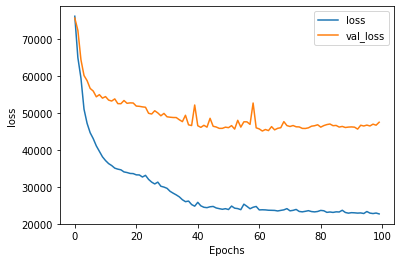

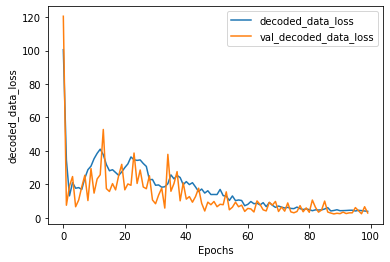

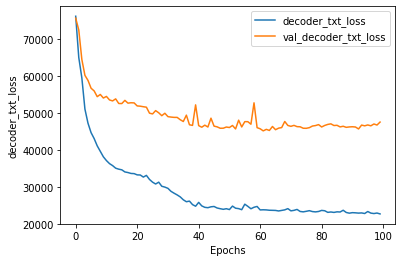

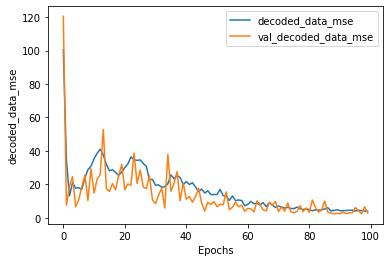

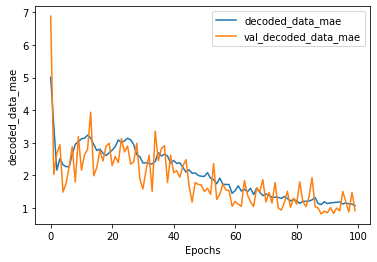

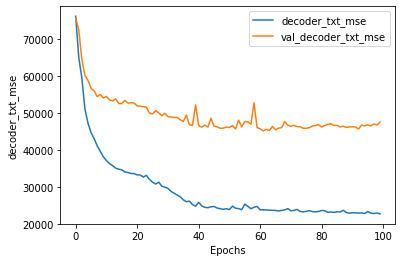

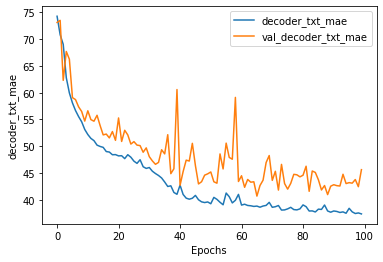

In [103]:
metrics = ['loss', 'decoded_data_loss', 'decoded_txt_loss', 'decoded_data_mse', 'decoded_data_mae', 'decoded_txt_mse', 'decoded_txt_mae']
for metric in metrics:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plot_name = '../results/' + metric + '.svg'
    plt.savefig(plot_name)
    plt.show()

In [130]:
final['decoded_txt'] = predicted['decoded_txt'].std(axis=1).tolist()
final['raw'] = predicted['decoded_txt'].tolist()
final['decoded_data'] = predicted['decoded_data'].mean(axis=1).tolist()
final = final.sort_values(by=['decoded_txt', 'decoded_data']).reset_index(drop=True)

,Cluster,Text,Original,Quantity,Price,decoder_txt,raw,decoded_data
0,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
1,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
2,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
3,120,SOLUCAO INJ DE RINGER C LACTATO 500ML FARMACE,SOLUCAO INJ. DE RINGER C/LACTATO 500ML [FARMACE],80,3.65,9.356417,"[30.239160537719727, 17.399988174438477, 24.14...",-0.075228
4,120,SOLUCAO INJ DE RINGER C LACTATO 500ML FARMACE,SOLUCAO INJ. DE RINGER C/LACTATO 500ML [FARMACE],600,3.65,9.356435,"[30.239334106445312, 17.400039672851562, 24.14...",-0.075230
5,506,CARVEDILOL 12 5MG C 30 CPR,"CARVEDILOL 12,5MG C/ 30 CPR",6,13.99,10.217038,"[30.739887237548828, 38.42416000366211, 22.050...",-0.102069
6,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,12000,2.74,10.253245,"[30.86022186279297, 37.571502685546875, 24.034...",-0.102800
7,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793
8,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793
9,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793


In [137]:
final.head(60)

,Cluster,Text,Original,Quantity,Price,decoder_txt,raw,decoded_data
0,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
1,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
2,120,SOLUCAO INJ DE RINGER C LACTATO 500ML,SOLUCAO INJ. DE RINGER C/LACTATO 500ML,120,3.65,9.227613,"[29.962799072265625, 17.255107879638672, 23.71...",-0.077205
3,120,SOLUCAO INJ DE RINGER C LACTATO 500ML FARMACE,SOLUCAO INJ. DE RINGER C/LACTATO 500ML [FARMACE],80,3.65,9.356417,"[30.239160537719727, 17.399988174438477, 24.14...",-0.075228
4,120,SOLUCAO INJ DE RINGER C LACTATO 500ML FARMACE,SOLUCAO INJ. DE RINGER C/LACTATO 500ML [FARMACE],600,3.65,9.356435,"[30.239334106445312, 17.400039672851562, 24.14...",-0.075230
5,506,CARVEDILOL 12 5MG C 30 CPR,"CARVEDILOL 12,5MG C/ 30 CPR",6,13.99,10.217038,"[30.739887237548828, 38.42416000366211, 22.050...",-0.102069
6,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,12000,2.74,10.253245,"[30.86022186279297, 37.571502685546875, 24.034...",-0.102800
7,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793
8,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793
9,5,SORO FISIOLOGICO 500ML FRESENIUS,SORO FISIOLOGICO 500ML FRESENIUS,300,2.70,10.253264,"[30.859718322753906, 37.58690643310547, 24.008...",-0.102793


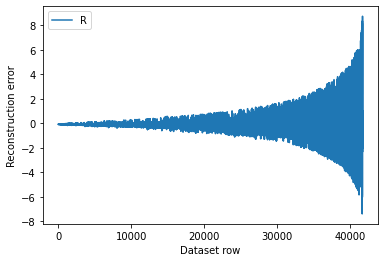

In [138]:
plt.plot(final['decoded_data'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()

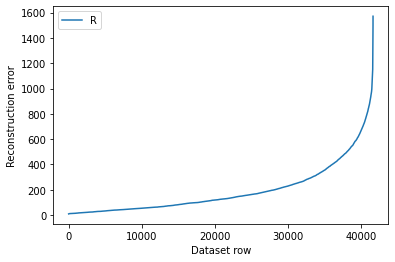

In [139]:
plt.plot(final['decoded_txt'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()

In [119]:
final.to_excel("../dataset/autoencoder.xlsx")